# Matching and Filtering

In [10]:
import sys
sys.path.append("../")
from putzlib import *
import matplotlib.pyplot as plt
%matplotlib inline

Now we have 64 images, each of which corresponds to a one of 6 black pieces, 6 white pieces, or an empty square. Looking through a few books I found the following three fonts (typefaces?) are the most common. 

![pieceset](./examples/pieceset.png)

**Note** the above come from scanned images, cleaned up a bit with Windows Paint. No orginal fonts etc. have been used. 

Now we have *reference templates* with which to compare our unknown image. 

A first approach might to treat the images as vectors and take dot products with each of the templates, suitably normalized. We would of course scale each image to a standard size so that the vectors are of equal lengths. Then the dot product is a crude measure of the overlap. 


    import numpy as np
    def overlap(im,template):
        im,template = np.float32(im),np.float32(template)
        return np.dot(im.flatten(),template.flatten())
    
    def piecematch(im,templates):
        matches = [overlap(im,temp) for temp in templates]
        return np.argmax(matches)

But this method only works if the image and templates are exactly aligned. Even a small offset will reduce the overlap substantially. 

![offset](./examples/offset.png) 

We need an algorithm that is **translation invariant**. We could try sliding the image around the template and computing the overlap (sum of the product of pixel values) at each point. The maximum of the these overlaps is the number we want. 

    import scipy.signal
    def overlap(im,template):
        im,template = np.float32(im),np.float32(template)
        template = np.pad(template,((8,8),(8,8)),mode='constant') #make space to slide 
        overs = scipy.signal.convolve2d(im,template[::-1,::-1],mode='valid')
        return overs.max()
        
    def piecematch(im,templates):
        matches = [overlap(im,temp) for temp in templates]
        return np.argmax(matches)

1. In the code, we take negatives of all images and rescale them to 32 * 32. The templates are normalized so that `overlap(temp,temp) = 1` 

2. The reason for reversing one of the arrays viz. `template[::-1,::-1]` is that convolution is defined to be $\sum_x f(x) g(-x)$ and we need $\sum_x f(x) g(x)$.

3. If none of the overlaps are above a certain cutoff, we may conclude that the image is a blank (white) square. 

We have rediscovered a technique for image recognition called **template matching** that has been around since the 80s. It works tolerably well part of the image as been cut off, as happens quite often. Note that it is still *not scale-invariant*.

## Filtering

The above works pretty well for the *white squares* getting to ~95% accuracy, which can be improved by a second pass that we'll come to later. 

But we run into difficulties with the *dark squares* that have some sort of striped background. 

![darkpieces](./examples/darkpieces.png)


### Blank squares

Neither the number nor the thickness of the stripes is a constant across fonts. But the pattern is suffiently regular to use Fourier methods. 

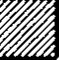

In [6]:
im = Image.open('./examples/zz76.png')
ima = np.bitwise_not(np.asarray(im))
Image.fromarray(ima)

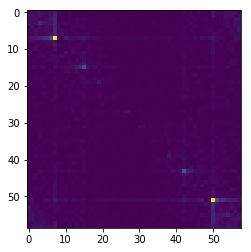

In [15]:
imf=np.fft.fft2(np.float32(ima))
plt.imshow(abs(imf)[1:,1:])

For clarity we have omitted the zero Fourier component on the top-left which is just the sum of the pixel values. If the stripes made up most of the image then we expect that the:

1. The Fourier peaks lie along a line orthogonal to the stripes as in the plot.

2. The amplitude squared of those peaks is comparable to the total value (recall Parseval).


In [ ]:
def stripetest(ima):
    '''check for stripe pattern in fft'''
    imf = np.fft.fft2(ima)
    x = -1
    for i in (-1,0,1):
        y = np.max(np.abs(imf.diagonal(i)[1:]))**2/np.abs(imf[0,0])**2
        x = max(x,y)
    return x

By testing on samples, `striptest(ima)>.15` detects ~95% of the blank squares which is good enough.

### Filtering stripes

Next we turn to the the dark squares that contain a single chess piece against a striped background. 

![darkpawn](./examples/bp0.png)

After a few (okay several) hours of experimentation and putzing with opencv docs, I settled on the following method: look for contours oriented close to 45 degree angle, and mask them out in the image.

In [32]:
im2 = Image.open('./examples/bp0.png')
ima2 = np.bitwise_not(np.asarray(im2))
imlarge = cv2.resize(ima2,(128,128),interpolation = cv2.INTER_CUBIC)
imacol = cv2.cvtColor(imlarge,cv2.COLOR_GRAY2BGR)

edges = cv2.Canny(imlarge,200,400,apertureSize = 3)
_,contours,_ = cv2.findContours(edges, 1, 2)
dashes = [c for c in contours if abs(cv2.minAreaRect(c)[2]+45)<8]                    

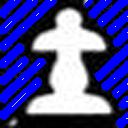

In [34]:
back = cv2.drawContours(imacol,dashes,-1,(0,0,255),4)
Image.fromarray(back)

That worked out almost too well. The separation will not be so neat when the stripes touch the main figure. A second pass of the same algorithm helps a bit.

In [35]:
def backfilter(ima,finalshape=(32,32),passes=2):
    imlarge = cv2.resize(ima,(128,128),interpolation = cv2.INTER_CUBIC)    
    for _ in range(passes):
        mask = np.zeros(imlarge.shape,np.uint8)
        ee = cv2.Canny(imlarge,200,400,apertureSize = 3)
        _,contours,_ = cv2.findContours(ee, 1, 2)
        dashes = [c for c in contours if abs(cv2.minAreaRect(c)[2]+45)<8]
        cv2.drawContours(mask,dashes,-1,255,4)
        imclean = np.where(mask==0,imlarge,0)
        imlarge = imclean
    return cv2.resize(imclean,finalshape,interpolation=cv2.INTER_AREA)

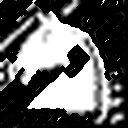

In [38]:
im3 = Image.open('./examples/bn6.png')
ima3 = np.bitwise_not(np.asarray(im3))
Image.fromarray(backfilter(ima3,finalshape=(128,128)))

Filtering seems to have removed part of the pattern too. But that is alright! We only care that the final image overlaps with one of the, say, white knight templates more than it does with any other. 